In [1]:
import os
import gc
import numpy as np
import pandas as pd
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Set precision to two decimals
pd.set_option("display.precision", 2)

# Charts inline
%matplotlib inline

In [3]:
print('Reading files.....')
path = '../child-mind-institute-detect-sleep-states/'
train_events = pd.read_csv(path + 'train_events.csv')
train_series = pd.read_parquet(path + 'train_series.parquet')
test_series = pd.read_parquet(path + 'test_series.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
print('..... done!')

Reading files.....
..... done!


## Data Analysis and Cleaning

In [4]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


In [5]:
train_events = train_events.dropna(axis=0, ignore_index=True)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9585 entries, 0 to 9584
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9585 non-null   object 
 1   night      9585 non-null   int64  
 2   event      9585 non-null   object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.5+ KB


## Remove records without onset and awake pair

In [6]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights[bad_nights['event']!=2]

,,event
series_id,night,
0ce74d6d2106,20,1
154fe824ed87,30,1
44a41bba1ee7,10,1
efbfc4526d58,7,1
f8a8da8bdd00,17,1


In [7]:
 train_events[(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
               ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
               ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |                
               ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
               ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))]

,series_id,night,event,step,timestamp
310,0ce74d6d2106,20,onset,332376.0,2017-09-09T22:08:00-0400
957,154fe824ed87,30,wakeup,514980.0,2019-02-25T09:45:00-0500
2668,44a41bba1ee7,10,wakeup,165684.0,2018-03-04T08:07:00-0500
9099,efbfc4526d58,7,wakeup,114864.0,2018-12-21T07:47:00-0500
9352,f8a8da8bdd00,17,wakeup,291384.0,2017-12-10T12:57:00-0500


In [8]:
train_events = train_events[~(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
                              ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
                              ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |                
                              ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
                              ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))].reset_index(drop=True)

train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9580 entries, 0 to 9579
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9580 non-null   object 
 1   night      9580 non-null   int64  
 2   event      9580 non-null   object 
 3   step       9580 non-null   float64
 4   timestamp  9580 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.3+ KB


In [9]:
series_list = list(train_events['series_id'].unique())
print('Total number of valid series in training dataset: '+ str(len(series_list)))

Total number of valid series in training dataset: 269


In [10]:
# Update train_series dataset with final set of series
train_series = train_series[train_series['series_id'].isin(series_list)].reset_index(drop=True)
# Check for nulls
train_series.isnull().any()

series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

## Visualizing the provided test subjects by Kaggle

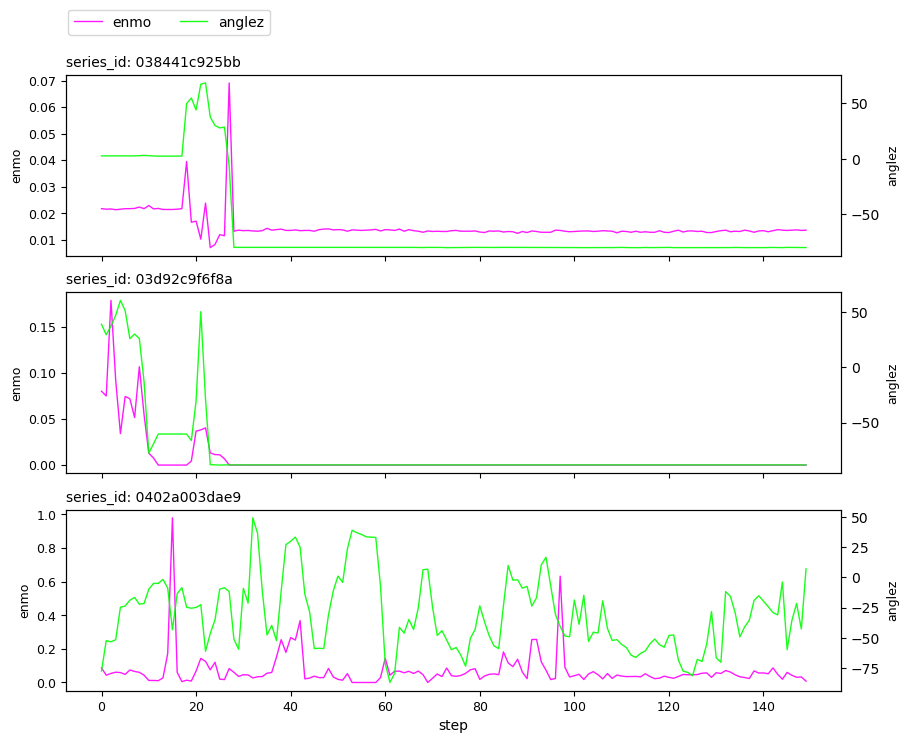

In [11]:
def plot_test_series():
    fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
    ax2 = {}
    i = 0
    test_series_list = list(test_series['series_id'].unique())
    for id in test_series_list:
        ax[i].set_title('series_id: ' + id, loc='left', fontsize=10)
        x = test_series[test_series['series_id']==id]['step']
        y_enmo = test_series[test_series['series_id']==id]['enmo']
        y_anglez = test_series[test_series['series_id']==id]['anglez']
        ax[i].plot(x, y_enmo, label='enmo', color='magenta', lw=1, alpha=0.9)
        ax[i].set_ylabel('enmo', fontsize=9)
        ax[i].tick_params(labelsize=9)
        ax2[i] = ax[i].twinx()
        ax2[i].plot(x, y_anglez, label='anglez', color='lime', lw=1, alpha=0.9)
        ax2[i].set_ylabel('anglez', fontsize=9)
        i = i + 1
    h1, l1 = ax[2].get_legend_handles_labels()
    h2, l2 = ax2[2].get_legend_handles_labels()
    plt.figlegend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.12, 0.97, 0.0, 0.0), ncols=2)
    ax[2].set_xlabel('step')
    plt.show()

# Plot it
plot_test_series()

In [12]:
test_series.isnull().any()

series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

In [13]:
sample_submission

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.0
1,1,038441c925bb,105,wakeup,0.0
2,2,03d92c9f6f8a,80,onset,0.5
3,3,03d92c9f6f8a,110,wakeup,0.5
4,4,0402a003dae9,90,onset,1.0
5,5,0402a003dae9,120,wakeup,1.0


## Creating cleaned data files

In [14]:
%%time
NBR_SAMPLES = len(series_list) # 200 # <-- adjust the sample using this, the lesser the faster
full_series = series_list
selected_series = random.sample(full_series, NBR_SAMPLES)
# selected_series = full_series

# Subsample data
train_series = train_series[train_series['series_id'].isin(selected_series)]
train_events = train_events[train_events['series_id'].isin(selected_series)]

# Merge train_series and train_events into a single fat dataframe
train_merged = pd.merge(train_series, train_events, on=['series_id', 'step', 'timestamp'], how='outer').reset_index(drop=True)

print('Nbr. of selected training series: ' + str(NBR_SAMPLES))
print('Nbr. of data points (timesteps): ' + str(len(train_merged)))
print()

Nbr. of selected training series: 269
Nbr. of data points (timesteps): 124822080

CPU times: user 5min 36s, sys: 26min 12s, total: 31min 48s
Wall time: 48min 10s


In [15]:
len(list(train_merged.series_id.unique()))

269

In [16]:
train_merged.to_parquet(path + f'train_merged_{NBR_SAMPLES}.parquet', index=False)


In [17]:
csv_file_path = path + f'selected_series_{NBR_SAMPLES}.csv'
with open(csv_file_path, 'w') as csv_file:
    # Write the list elements separated by commas
    csv_file.write(','.join(selected_series))
print(f'Data has been written to {csv_file_path}')

Data has been written to ../child-mind-institute-detect-sleep-states/selected_series_269.csv
